# Acknowledgements

## Polynomial fitting
Amazing **notebooks** about curve fitting and confidence intervals

https://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
https://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/ConfidencePredictionIntervals.ipynb

Basic reminder about confidence intervals, prediction intervals and a common misconception:

> The 95% CI means that if we randomly obtain 100 samples of a population and calculate the CI of each sample (i.e., we replicate the experiment 99 times in a independent way), 95% of these CIs should contain the population mean (the true mean). This is **different from the prediction interval**, which is larger, and gives the **probability that a new observation is inside this interval**. Note that the confidence interval **DOES NOT give the probability that the true mean (the mean of the population) is inside this interval**. The true mean is a parameter (fixed) and it is either inside the calculated interval or not; it is not a matter of chance (probability). >

Code: Thank you Stackoverflow!!

https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

## Locally weighted running line smoother

Code from João Paulo Figueira's github repo

https://towardsdatascience.com/loess-373d43b03564
https://github.com/joaofig/pyloess

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = pd.read_csv("files/csv/exported_counts_050421.csv")
data.head(5)

,Unnamed: 0,ID,number_cells,somite_stage
0,1,18ss_1,80,18ss
1,2,18ss_10,40,18ss
2,3,18ss_11,77,18ss
3,4,18ss_12,63,18ss
4,5,18ss_13,35,18ss


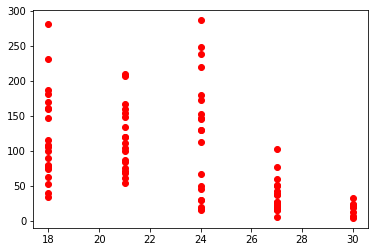

In [4]:
x = data.somite_stage.str.split("ss").str[0].values
x = [int(i) for i in x]
y = data.number_cells.values
fig, ax = plt.subplots(1, 1)
ax.plot(x,y,'ro')

# Fitting with second-order polynomial

In [5]:
#Code adapted from https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    #print("Confidence interval", ci)
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

    return ax

def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = np.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, np.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax

## Plot

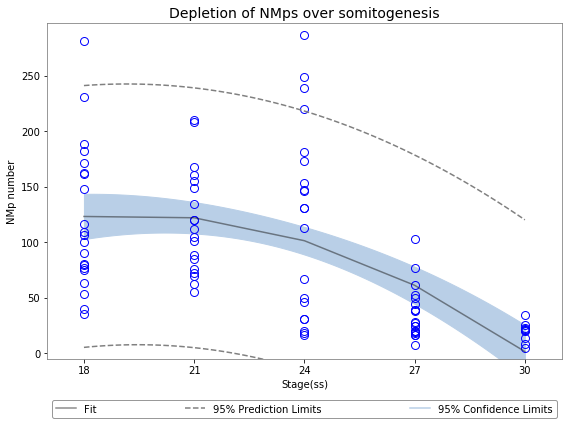

In [6]:
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 2, cov=True)  # parameters and covariance from of the fit of 1-D polynom.
model = np.poly1d(p)
y_model = equation(p, x)                # model using the fit parameters; NOTE: parameters here are coefficients#

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof  # reduced chi-squared; measures goodness of fit
#print(chi2_red)
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(x, y, "o", color="#b9cfe7", markersize=8, markeredgewidth=1, markeredgecolor="b", markerfacecolor="None")
#ax.plot(x, y, "o", color="#b9cfe7", markersize=8)
# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)

# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Figure Modifications --------------------------------------------------------
# Borders
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")
ax.get_xaxis().set_tick_params(direction="out")
ax.get_yaxis().set_tick_params(direction="out")
ax.xaxis.tick_bottom()
ax.yaxis.tick_left() 

# Labels
plt.title("Depletion of NMps over somitogenesis", fontsize="14")
plt.xlabel("Stage(ss)")
plt.ylabel("NMp number")
plt.xlim(np.min(x) - 1, np.max(x) + 1)
plt.ylim(np.min(y) - 10, np.max(y) + 10)

unique_x_vals = [i for i in set(x)]
plt.xticks(unique_x_vals)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
)  
frame = legend.get_frame().set_edgecolor("0.5")

# Save Figure
plt.tight_layout()
plt.savefig("images/fitted_curve_nmpcounts.png", bbox_extra_artists=(legend,), bbox_inches="tight")

## Statistics

In [7]:
import statsmodels.formula.api as smf
results = smf.ols(formula='y ~ model(x)', data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     41.44
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           6.19e-09
Time:                        14:26:01   Log-Likelihood:                -492.31
No. Observations:                  90   AIC:                             988.6
Df Residuals:                      88   BIC:                             993.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.134e-12     15.358  -7.38e-14      1.000     -30.522      30.522
model(x)       1.0000      0.155      6.438      0.000       0.691       1.309
==============================================================================
Omnibus:                       14.085   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.324
Skew:                           0.934   Prob(JB):                     0.000470
Kurtosis:                       3.773   Cond. No.                         248.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking normality of residuals

Checking assumption that residuals are normally distributed. This is important as we are fitting the parameters by minimizing the chi-squared statistic, which assumes normality.


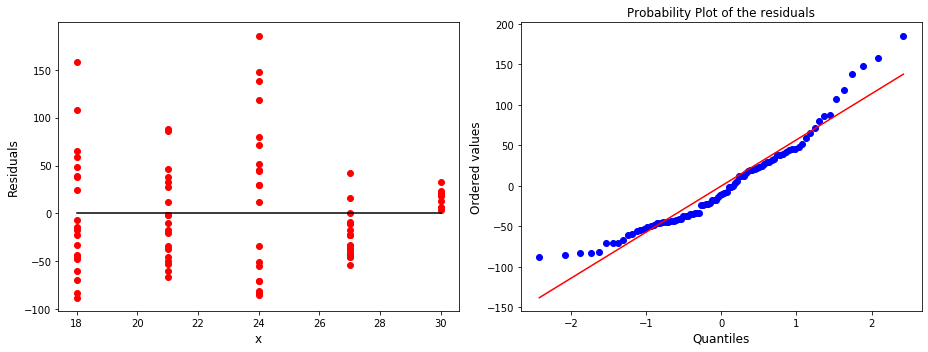

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].plot(x, resid, 'ro')
ax[0].plot([x[0], x[-1]], [0, 0], 'k')
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('Residuals', fontsize=12)
stats.probplot(resid, dist="norm", plot=plt)
ax[1].set_xlabel('Quantiles', fontsize=12)
ax[1].set_ylabel('Ordered values', fontsize=12)
ax[1].set_title('Probability Plot of the residuals')

plt.tight_layout()
plt.savefig("images/residuals.png",bbox_inches="tight")




# Fitting with LOESS

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pyloess.pyloess.Loess import Loess
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline

/home/porcupine/miniconda3/envs/toggleSwitch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
xx = np.linspace(np.min(x), np.max(x), 100)

In [11]:
yy = np.zeros_like(xx)

In [17]:
loess = Loess(x, y)

In [58]:
k = 60

In [59]:
for i in range(len(xx)):
    yy[i] = loess.estimate(xx[i], window=k)

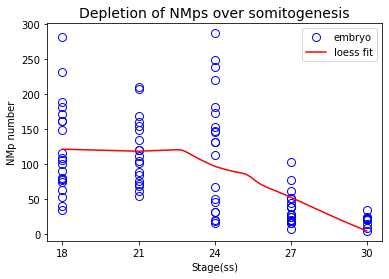

In [60]:
unique_x_vals = [i for i in set(x)]
plt.xticks(unique_x_vals)
#plt.plot(x_noise, y_signal, "r")
plt.plot(x, y, "o", color="#b9cfe7", markersize=8, markeredgewidth=1, markeredgecolor="b", markerfacecolor="None", label = "embryo")
plt.plot(xx, yy, "r", label = "loess fit")
plt.title("Depletion of NMps over somitogenesis", fontsize="14")
plt.xlabel("Stage(ss)")
plt.ylabel("NMp number")
plt.legend(loc="upper right")
plt.savefig("images/loess_fit.png",bbox_inches="tight")
#plt.plot(x2, y2, "r")

In [61]:
np.save('loess_fit_vals_050421', yy)